In [52]:
import numpy as np 
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder

# vint=np.vectorize(int)

def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    # x = 2*(0.5 - x/255)
    mean = np.mean(x,axis=0)
    std = np.std(x,axis=0)
    x=(x-mean)/(std+0.0001)
    return x, y, mean, std

def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
                
    '''
    results = classification_report(y_pred, y_true)
    return results

In [53]:
x_train_path = "x_train.npy"
y_train_path = "y_train.npy"
x_test_path = "x_test.npy"
y_test_path = "y_test.npy"

X_train, y_train, mean, std = get_data(x_train_path, y_train_path)
X_test = np.load(x_test_path)
y_test = np.load(y_test_path)
X_test = (X_test - mean)/(std+0.0001)

#you might need one hot encoded y in part a,b,c,d,e
label_encoder = OneHotEncoder(sparse_output = False)
label_encoder.fit(np.expand_dims(y_train, axis = -1))

y_train_onehot = label_encoder.transform(np.expand_dims(y_train, axis = -1))
y_test_onehot = label_encoder.transform(np.expand_dims(y_test, axis = -1))

In [54]:
def softmax(z):
    z = z - np.max(z,axis=1).reshape(-1,1)
    exp_z = np.exp(z)
    softmax = exp_z / np.sum(exp_z,axis=1).reshape(-1,1)
    return softmax

def sigmoid(z):
    return 1/(1+np.exp(-z))

def cross_entropy_loss(y, y_hat):
    loss = -np.mean(y*np.log(y_hat))
    return loss
def relu(z):
    return np.maximum(0,z)

In [55]:
class NeuralNetwork():
    def __init__(self, input_size, hidden_layer, output_size, learning_rate):
        self.learning_rate = learning_rate
        self.theta=[np.random.randn(hidden_layer[0],input_size)/np.sqrt(input_size/2)]
        self.b=[np.random.randn(hidden_layer[0],1)/np.sqrt(input_size/2)]
        if len(hidden_layer) > 1:
            for i in range(1,len(hidden_layer)):
                self.theta.append(np.random.randn(hidden_layer[i],hidden_layer[i-1])/np.sqrt(hidden_layer[i-1]/2))
                self.b.append(np.random.randn(hidden_layer[i],1)/np.sqrt(hidden_layer[i-1]/2))
        self.theta.append(np.random.randn(output_size,hidden_layer[-1])/np.sqrt(hidden_layer[-1]/2))
        self.b.append(np.random.randn(output_size,1)/np.sqrt(hidden_layer[-1]/2))
        # self.theta=[np.random.normal(loc=0, scale=var, size=(hidden_layer[0],input_size))]
        # self.b=[np.random.normal(loc=0, scale=var, size=(hidden_layer[0],1))]
        # if len(hidden_layer) > 1:
        #     for i in range(1,len(hidden_layer)):
        #         self.theta.append(np.random.normal(loc=0, scale=var, size=(hidden_layer[i],hidden_layer[i-1])))
        #         self.b.append(np.random.normal(loc=0, scale=var, size=(hidden_layer[i],1)))
        # self.theta.append(np.random.normal(loc=0, scale=var, size=(output_size,hidden_layer[-1])))
        # self.b.append(np.random.normal(loc=0, scale=var, size=(output_size,1)))
    def forward(self, X):
        self.O=[]
        for l in range(len(self.theta)):
            if l == 0:
                z = np.dot(X,self.theta[l].T)+self.b[l].T
                '''print("aa")
                print(X.shape)
                print(self.theta[l].T.shape)
                print(z.shape)
                print("aa")
                """
                aa
                (32, 1024)
                (1024, 10)
                (32, 10)
                aa
                """
                '''
            else:
                z = np.dot(zz,self.theta[l].T)+self.b[l].T
            if l == len(self.theta)-1:
                self.y_predict = softmax(z)
                self.O.append(self.y_predict)
            else:
                zz = sigmoid(z)
                self.O.append(zz)
        return self.y_predict

    def backward(self, y_true, y_pred):
        #Calculating deltas (del J / del net = -delta)
        self.delta = [0]*len(self.theta)             #storing +deltas
        for l in range(len(self.theta)-1,-1,-1):
            if l == len(self.theta)-1:
                self.delta[l]=y_true-y_pred
            else:
                temp=[]
                # for k in range(len(self.theta[l])):
                #     temp.append(np.dot(self.delta[l+1],self.theta[l+1][:,k])*self.O[l][:,k]*(1-self.O[l][:,k]))
                # self.delta[l]=np.array(temp).T
                self.delta[l]=np.dot(self.delta[l+1],self.theta[l+1])*self.O[l]*(1-self.O[l])
        return self.delta
    
    def update(self, delta, X):
        #Updating weights
        for l in range(len(self.theta)):
            if l==0:
                aaa=np.matmul(delta[l].T,X)
                # print(aaa.shape)
                self.theta[l] = self.theta[l] + self.learning_rate*aaa/len(X)
            else:
                aaa=np.matmul(delta[l].T,self.O[l-1])
                # print(aaa.shape)
                # print(delta[l].shape)
                self.theta[l] = self.theta[l] + self.learning_rate*aaa/len(X)
            self.b[l] = self.b[l] + self.learning_rate*np.sum(delta[l],axis=0, keepdims=True).T/len(X)
        

    def train(self, X, y_true, batch_size, num_epochs):
        loss=0
        for epoch in range(num_epochs):
            perm=np.random.permutation(X.shape[0])
            X=X[perm]
            y_true=y_true[perm]
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y_true[i:i+batch_size]
                y_pred = self.forward(X_batch)
                delta = self.backward(y_batch, y_pred)
                self.update(delta,X_batch)
            n=10
            if epoch%n==0 and epoch!=0:
                # print("Epoch: ", epoch+1)
                # loss = cross_entropy_loss(y_batch, y_pred)
                y_pred = self.forward(X)
                # print("Accuracy: ", self.accuracy(y_true, y_pred))
                if epoch!=n:
                    if abs((old_loss-loss)/loss)<0.005:
                        break
                # print("Loss: ", cross_entropy_loss(y_true, y_pred))
                old_loss=loss
                loss=0
            else:
                loss+=cross_entropy_loss(y_batch, y_pred)

    def accuracy(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 1)
        y_true = np.argmax(y_true, axis = 1)
        return np.mean(y_pred == y_true)
    
    def predict(self, X):
        y_pred = self.forward(X)
        return y_pred


In [56]:
d1={}
d2={}
d={}
c=0
for aa in [[512],[512,256],[512,256,128],[512,256,128,64]]:
    c+=1
    input_size = 1024           #n
    hidden_layer = aa
    output_size = 5             #r
    learning_rate = 0.01        #eta
    batch_size = 32             #M
    num_epochs = 100

    model = NeuralNetwork(input_size, hidden_layer, output_size, learning_rate)
    model.train(X_train, y_train_onehot, batch_size, num_epochs)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("Train Accuracy: ", model.accuracy(y_train_onehot, y_pred_train))
    print("Test Accuracy: ", model.accuracy(y_test_onehot, y_pred_test))

    y_pred_train = np.argmax(y_pred_train, axis = 1)
    y_pred_test = np.argmax(y_pred_test, axis = 1)
    y_true_train = np.argmax(y_train_onehot, axis = 1)
    y_true_test = np.argmax(y_test_onehot, axis = 1)
    d[c]=model
    d1[c]=get_metric(y_true_train, y_pred_train)
    d2[c]=get_metric(y_true_test, y_pred_test)

Train Accuracy:  0.9552
Test Accuracy:  0.861


KeyboardInterrupt: 

In [ ]:
for t in d1:
    print(t)
    print(d1[t])
for t in d2:
    print(t)
    print(d2[t])

1
              precision    recall  f1-score   support

           0       1.00      0.62      0.76      3187
           1       0.36      0.80      0.50       889
           2       0.70      0.89      0.78      1527
           3       0.07      0.41      0.12       336
           4       1.00      0.51      0.68      4061

    accuracy                           0.63     10000
   macro avg       0.62      0.65      0.57     10000
weighted avg       0.87      0.63      0.69     10000

5
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1980
           1       0.96      0.95      0.95      2000
           2       0.84      0.90      0.87      1822
           3       0.79      0.81      0.80      1974
           4       0.92      0.87      0.89      2224

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

10
              p

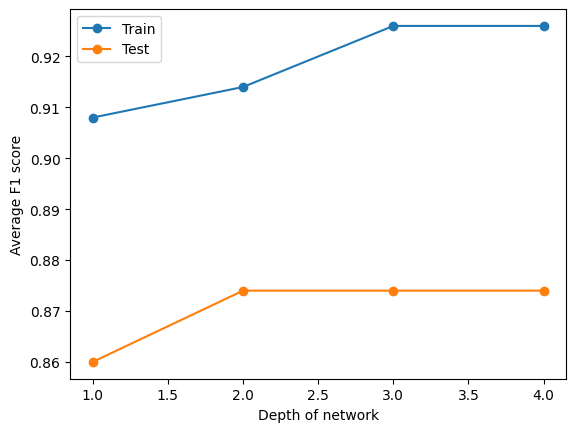

In [60]:
fx=[1,2,3,4]
ftrain=[0.908,0.914,0.926,0.926]
ftest=[0.86,0.874,0.874,0.874]
plt.plot(fx,ftrain,'o-')
plt.plot(fx,ftest,'o-')
plt.xlabel("Depth of network")
plt.ylabel("Average F1 score")
plt.legend(["Train","Test"])
plt.show()